In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk.stem import LancasterStemmer

import re 
import string

from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score,fbeta_score
from sklearn.decomposition import NMF
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import xgboost as xgb

pd.set_option('display.max_colwidth', -1)

/Users/evaxu/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# read in data from Kaggle
df = pd.read_csv('/Users/evaxu/Desktop/Metis/Local_Projects_files/project_4/Airline2015_Tweets.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760000,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,NaN,Eastern Time (US & Canada)
1,570301130888122000,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
2,570301083672813000,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2/24/15 11:15,Lets Play,Central Time (US & Canada)
3,570301031407624000,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
4,570300817074462000,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2/24/15 11:14,NaN,Pacific Time (US & Canada)


In [5]:
data = df.copy()
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

# Cleaning and EDA

## Deleting duplicated tweetid

In [6]:
tweetid = data[['tweet_id']] 
dupes = data[tweetid.duplicated()].index
dupes
# Looking at example of dupe tweet id : 570308309682675000
data[data['tweet_id']==570308309682675000] # The tweet text is the same

# Remove duplicates
data.drop(index = dupes, inplace = True)

In [7]:
data = data.reset_index()

## DF with relevant columns

In [8]:
columns = ['airline_sentiment', 'airline',
       'text']
data = data.loc[:,columns]

In [9]:
data.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it


## QUICK EDA:

In [10]:
# Mostly negative reviews
data['airline_sentiment'].value_counts(normalize=True)

negative    0.626993
neutral     0.211874
positive    0.161132
Name: airline_sentiment, dtype: float64

In [11]:
# United has the most reviews, Virgin America has the least
# All other airlines are mostly equal # of reviews
data['airline'].value_counts(normalize=True)

United            0.263859
US Airways        0.201105
American          0.179772
Southwest         0.167069
Delta             0.153400
Virgin America    0.034795
Name: airline, dtype: float64

In [12]:
# Distribution of sentiment grouped by Airline still skew to negative, except for Virgin America
data.groupby(['airline'])['airline_sentiment'].value_counts(normalize=True)

airline         airline_sentiment
American        negative             0.715822
                neutral              0.166283
                positive             0.117896
Delta           negative             0.429793
                neutral              0.325383
                positive             0.244824
Southwest       negative             0.490083
                neutral              0.274380
                positive             0.235537
US Airways      negative             0.776862
                neutral              0.130793
                positive             0.092345
United          negative             0.688906
                neutral              0.182365
                positive             0.128728
Virgin America  negative             0.359127
                neutral              0.339286
                positive             0.301587
Name: airline_sentiment, dtype: float64

# PreProcessing


## remove the @airline in ['text'] since information is already captured in ['airline']

In [13]:
for i in range(len(data)):
    airline = data.loc[i, 'airline']
    if airline == 'Virgin America':
        data.loc[i,'text'] = data.loc[i, 'text'].replace('@VirginAmerica','')
    if airline == 'United':
        data.loc[i,'text'] = data.loc[i, 'text'].replace('@united','')
    if airline == 'Southwest':
        data.loc[i,'text'] = data.loc[i, 'text'].replace('@SouthwestAir','')
    if airline == 'Delta':
        data.loc[i,'text'] = data.loc[i, 'text'].replace('@JetBlue','')
    if airline == 'US Airways':
        data.loc[i,'text'] = data.loc[i, 'text'].replace('@USAirways','')
    if airline == 'American':
        data.loc[i,'text'] = data.loc[i, 'text'].replace('@AmericanAir','')

In [14]:
data.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,What @dhepburn said.
1,positive,Virgin America,plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,Virgin America,and it's a really big bad thing about it


## Convert sentiment target to integers: Negative vs  Positive&Neutral

In [15]:
mapping_sentiment = {'neutral':1 , 'negative':0, 'positive':1}
data['airline_sentiment'] = data['airline_sentiment'].map(mapping_sentiment)

In [16]:
data.head()

,airline_sentiment,airline,text
0,1,Virgin America,What @dhepburn said.
1,1,Virgin America,plus you've added commercials to the experience... tacky.
2,1,Virgin America,I didn't today... Must mean I need to take another trip!
3,0,Virgin America,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,0,Virgin America,and it's a really big bad thing about it


# Preprocessing : Text

In [17]:
sentiment_text = data[['airline_sentiment','text']]
sentiment_text.head()

,airline_sentiment,text
0,1,What @dhepburn said.
1,1,plus you've added commercials to the experience... tacky.
2,1,I didn't today... Must mean I need to take another trip!
3,0,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,0,and it's a really big bad thing about it


## Step 1: Removing URLs, Numbers, Punctuation, Capital Letters

In [18]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams

def clean_text_round1 ():
    ''' remove: urls;
    lowercase text;
    remove: punctuations and numbers'''
    
    urls = lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)
    alphanumeric= lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())
    
    # consider replacing ' ' with '' to remove space between I ' m to I'm
    sentiment_text.loc[:,'text'] = sentiment_text.loc[:,'text'].map(urls).map(alphanumeric).map(punc_lower)

clean_text_round1()

/Users/evaxu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
def clean_text_round2 ():
    ''' remove words that appeared repeatedly i.e. variations of "flight" '''
    
    mask = sentiment_text.loc[:,'text'].str.contains('flighted')
    for index, row in sentiment_text.loc[mask].iterrows(): 
        sentiment_text.loc[index,'text']=row['text'].replace('flighted', 'flight')
    mask = sentiment_text.loc[:,'text'].str.contains('flightled')
    for index, row in sentiment_text.loc[mask].iterrows(): 
        sentiment_text.loc[index,'text']=row['text'].replace('flightled', 'flight')
    mask = sentiment_text.loc[:,'text'].str.contains('flights')
    for index, row in sentiment_text.loc[mask].iterrows(): 
        sentiment_text.loc[index,'text']=row['text'].replace('flights', 'flight')
    mask = sentiment_text.loc[:,'text'].str.contains('flightr')
    for index, row in sentiment_text.loc[mask].iterrows(): 
        sentiment_text.loc[index,'text']=row['text'].replace('flightr', 'flight')
    mask = sentiment_text.loc[:,'text'].str.contains('\n')
    for index, row in sentiment_text.loc[mask].iterrows(): 
        sentiment_text.loc[index,'text']=row['text'].replace('\n', ' ')

clean_text_round2()

In [21]:
sentiment_text.head()

,airline_sentiment,text
0,1,what dhepburn said
1,1,plus youve added commercials to the experience tacky
2,1,i didnt today must mean i need to take another trip
3,0,its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
4,0,and its a really big bad thing about it


## Step 2: Considerations using tokenizing and stemming

In [22]:
sentiment_text_considerations = sentiment_text.copy()

In [23]:
# consider word tokenization and regex: whitespace

whitespace_tokenizer = RegexpTokenizer('\s+', gaps = True)

whitespace_tokenizer_map = lambda x: whitespace_tokenizer.tokenize(x)

sentiment_text_considerations.loc[:,'text'] = sentiment_text_considerations.loc[:,'text'].map(whitespace_tokenizer_map)
sentiment_text_considerations.head()

,airline_sentiment,text
0,1,"[what, dhepburn, said]"
1,1,"[plus, youve, added, commercials, to, the, experience, tacky]"
2,1,"[i, didnt, today, must, mean, i, need, to, take, another, trip]"
3,0,"[its, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, amp, they, have, little, recourse]"
4,0,"[and, its, a, really, big, bad, thing, about, it]"


I tried stemming, but I realized that for my data, stemming did not help:

In [24]:
# cleans text further to the form of a root word
stemmer = LancasterStemmer() 
stemmer_text = lambda x: stemmer.stem(x)
# sent_text_clean.loc[:,'text_stemmed'] = sent_text_clean.loc[:,'text'].map(stemmer_text)

In [25]:
test_stem = sentiment_text_considerations.loc[1,'text']
[stemmer.stem(x) for x in test_stem]

['plu', 'youv', 'ad', 'commerc', 'to', 'the', 'expery', 'tacky']

## Pickle cleaned tweets

I decided stemming was unnecessary, and that sentiment_text was the best preprocessed copy of my dataframe.

In [26]:
with open('./sentiment_text.pkl','wb') as picklefile:
    pickle.dump(sentiment_text, picklefile)

# Tokenization

## Train Test Split

In [28]:
# Split the data into X and y data sets
X = sentiment_text['text']
y = sentiment_text['airline_sentiment']

In [29]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Count Vectorizer (removed stopwords)

In [30]:
cv = CountVectorizer(stop_words='english')
X_train_cv= cv.fit_transform(X_train)
X_test_cv= cv.transform(X_test)

In [31]:
X_train_cv.shape

(10139, 10377)

In [39]:
cv_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names()).head(5)

In [40]:
cv_df

,aa,aaaand,aaalwayslate,aaba,aacom,aacustomerservice,aadfw,aadv,aadvantage,aafail,...,zfv,zigzagging,zip,zkatcher,zone,zones,zoom,zrhairport,zurich,zurichnew
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF Vectorizer (removed stopwords)

In [41]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_fit = tfidf.fit(X_train)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf= tfidf.transform(X_test)

tfidf_all = TfidfVectorizer(stop_words='english')
X_all = tfidf_all.fit_transform(sentiment_text.iloc[:,1])


In [42]:
tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), index=X_train, columns=tfidf.get_feature_names()).head(10)

In [43]:
tfidf_df.head()

,aa,aaaand,aaalwayslate,aaba,aacom,aacustomerservice,aadfw,aadv,aadvantage,aafail,...,zfv,zigzagging,zip,zkatcher,zone,zones,zoom,zrhairport,zurich,zurichnew
text,,,,,,,,,,,,,,,,,,,,,
yep they moved me to as they showed me flying standby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
i dmed you the details,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
thanks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
likelihood of phl to bdl actually leaving tonight hour delay so far,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
want to make my day friend is premier amp i should be soon any chance you can upgrade our two hr leg of flight to ecom plus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF Vectorizer with 2ngram

In [44]:
tfidf_2ngram = TfidfVectorizer(stop_words='english',ngram_range=(2,2))

X_train_tfidf_2ngram = tfidf_2ngram.fit_transform(X_train)
X_test_tfidf_2ngram= tfidf_2ngram.transform(X_test)

In [45]:
tfidf_df_2ngram = pd.DataFrame(X_train_tfidf_2ngram.toarray(), index=X_train, columns=tfidf_2ngram.get_feature_names()).head(10)

In [46]:
tfidf_df_2ngram.head()

,aa able,aa account,aa accounts,aa advantage,aa agent,aa agents,aa air,aa airline,aa amp,aa automated,...,zone forced,zone space,zones thanks,zoom sauce,zoom scroll,zrhairport replacing,zurich credit,zurich jfk,zurich zrhairport,zurichnew york
text,,,,,,,,,,,,,,,,,,,,,
yep they moved me to as they showed me flying standby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
i dmed you the details,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
thanks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
likelihood of phl to bdl actually leaving tonight hour delay so far,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
want to make my day friend is premier amp i should be soon any chance you can upgrade our two hr leg of flight to ecom plus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classification of Tweets

### Log Reg - Finding the best hyperparameter C

In [47]:
c_space = np.logspace(-5, 8, 15) 

tuned_parameters = {'C': c_space}

m = LogisticRegression(class_weight= {0:.6,1:1})
gridLogReg = GridSearchCV(m, tuned_parameters, cv=5)
gridLogReg.fit(X_train_tfidf, y_train)

print("Tuned Logistic Regression Parameters: {}".format(gridLogReg.best_params_))  
print("Best score is {}".format(gridLogReg.best_score_)) 

/Users/evaxu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Tuned Logistic Regression Parameters: {'C': 3.727593720314938}
Best score is 0.8057007594437321


# Modeling & Class Balance

I tried the following models, with weighted class balance.

In [48]:
Classifiers_weighted= [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    LogisticRegression(C=3.727593720314938,solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    LogisticRegression(C=.2727593720314938,solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    LogisticRegression(solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(class_weight= {0:.6,1:1}),
    RandomForestClassifier(class_weight= {0:.6,1:1}, n_estimators=200, max_depth=3,oob_score=True,random_state=42),
    GaussianNB(),
    ]

In [49]:
Accuracy=[]
Model=[]
def classification_tfidf_weighted (X_train_tfidf, X_test_tfidf):
    for classifier in Classifiers_weighted:
        try:
            fit = classifier.fit(X_train_tfidf, y_train)
            y_pred = fit.predict(X_test_tfidf)
        except:
            fit = classifier.fit(X_train_tfidf.toarray(),y_train)
            y_pred = fit.predict(X_test_tfidf.toarray())

        
        accuracy = accuracy_score(y_test,y_pred)    
        Accuracy.append(accuracy)
        Model.append(classifier)

        
        print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))
        print(classification_report(y_test, y_pred))



In [50]:
classification_tfidf_weighted(X_train_cv, X_test_cv)

Accuracy of LogisticRegression is 0.7519558214450069
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2782
           1       0.67      0.62      0.64      1564

    accuracy                           0.75      4346
   macro avg       0.73      0.72      0.73      4346
weighted avg       0.75      0.75      0.75      4346

Accuracy of LogisticRegression is 0.8048780487804879
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      2782
           1       0.70      0.80      0.75      1564

    accuracy                           0.80      4346
   macro avg       0.79      0.80      0.79      4346
weighted avg       0.81      0.80      0.81      4346

Accuracy of LogisticRegression is 0.8080994017487345
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      2782
           1       0.69      0.84      0.76      1564

    accuracy           

In [67]:
classification_tfidf_weighted(X_train_tfidf, X_test_tfidf)

Accuracy of LogisticRegression is 0.3796594569719282
              precision    recall  f1-score   support

           0       0.93      0.03      0.06      2782
           1       0.37      1.00      0.54      1564

    accuracy                           0.38      4346
   macro avg       0.65      0.51      0.30      4346
weighted avg       0.73      0.38      0.23      4346

Accuracy of LogisticRegression is 0.8189139438564197
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2782
           1       0.73      0.79      0.76      1564

    accuracy                           0.82      4346
   macro avg       0.80      0.81      0.81      4346
weighted avg       0.82      0.82      0.82      4346

Accuracy of LogisticRegression is 0.8071790151863782
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      2782
           1       0.71      0.79      0.75      1564

    accuracy           

Cross Validation:

In [51]:
Classifiers_weighted= [
    LogisticRegression(C=0.000000001,solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    LogisticRegression(C=3.727593720314938,solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    LogisticRegression(C=.2727593720314938,solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    LogisticRegression(solver='liblinear',max_iter=200, class_weight= {0:.6,1:1}),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(class_weight= {0:.6,1:1}),
    RandomForestClassifier(class_weight= {0:.6,1:1}, n_estimators=200, max_depth=3,oob_score=True,random_state=42),
    ]

In [52]:
def classification_tfidf_weighted_cross_validate (X_train_tfidf, X_test_tfidf):
    for classifier in Classifiers_weighted:
        try:
            fit = classifier.fit(X_train_tfidf, y_train)
            y_pred = fit.predict(X_test_tfidf)
        except:
            fit = classifier.fit(X_train_tfidf.toarray(),y_train)
            y_pred = fit.predict(X_test_tfidf.toarray())       
        print(classifier.__class__.__name__)
                 
        classifier_crossval = pd.DataFrame(cross_validate(classifier, X_train_tfidf, y_train, cv=5, scoring=['accuracy','precision','recall','f1'], return_train_score=True))
        print(classifier_crossval.mean())

In [54]:
classification_tfidf_weighted_cross_validate (X_train_cv, X_test_cv)

LogisticRegression
fit_time           0.014007
score_time         0.009430
test_accuracy      0.751258
train_accuracy     0.763290
test_precision     0.686864
train_precision    0.704234
test_recall        0.630891
train_recall       0.646392
test_f1            0.657609
train_f1           0.674047
dtype: float64
LogisticRegression
fit_time           0.093070
score_time         0.010060
test_accuracy      0.796430
train_accuracy     0.958995
test_precision     0.707669
train_precision    0.922186
test_recall        0.787709
train_recall       0.973886
test_f1            0.745443
train_f1           0.947330
dtype: float64
LogisticRegression
fit_time           0.033732
score_time         0.009448
test_accuracy      0.799487
train_accuracy     0.874593
test_precision     0.699909
train_precision    0.790981
test_recall        0.823396
train_recall       0.909026
test_f1            0.756586
train_f1           0.845902
dtype: float64
LogisticRegression
fit_time           0.054614
score_time 

In [53]:
classification_tfidf_weighted_cross_validate (X_train_tfidf, X_test_tfidf)

LogisticRegression
fit_time           0.010907
score_time         0.008170
test_accuracy      0.395700
train_accuracy     0.397697
test_precision     0.384933
train_precision    0.385760
test_recall        0.996875
train_recall       0.997330
test_f1            0.555403
train_f1           0.556334
dtype: float64
LogisticRegression
fit_time           0.037536
score_time         0.007278
test_accuracy      0.805701
train_accuracy     0.925387
test_precision     0.722817
train_precision    0.879206
test_recall        0.789531
train_recall       0.930841
test_f1            0.754565
train_f1           0.904283
dtype: float64
LogisticRegression
fit_time           0.023744
score_time         0.007557
test_accuracy      0.795148
train_accuracy     0.844980
test_precision     0.704363
train_precision    0.766204
test_recall        0.790834
train_recall       0.850026
test_f1            0.744970
train_f1           0.805927
dtype: float64
LogisticRegression
fit_time           0.122270
score_time 

The Logistic Regression Model that was picked with parameter C = 3.727 from GridSearchCV (cv=5) has the best accuracy.

# Try XGBoost (but it was not as good as Log Reg)

## Weighted and Cross Validated

In [121]:
gb_weighted = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100, max_depth=3, learning_rate=.1, scale_pos_weight=1.66)
gb_cv_weighted = pd.DataFrame(cross_validate(gb_weighted, X_train_tfidf, y_train, cv=5, scoring=['accuracy','precision','recall','f1'], return_train_score=True))

In [122]:
gb_cv_weighted.mean()

fit_time           6.079654
score_time         0.068174
test_accuracy      0.717625
train_accuracy     0.749482
test_precision     0.589401
train_precision    0.618238
test_recall        0.840063
train_recall       0.884670
test_f1            0.692632
train_f1           0.727836
dtype: float64

In [123]:
gb_weighted = xgb.XGBClassifier(objective='binary:logistic',n_estimators=100, max_depth=3, learning_rate=.1, scale_pos_weight=1.66)
gb_weighted = gb_weighted.fit(X_train_tfidf,y_train)
y_pred = gb_weighted.predict(X_test_tfidf)

In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.66      0.76      2782
           1       0.59      0.84      0.69      1564

    accuracy                           0.73      4346
   macro avg       0.73      0.75      0.72      4346
weighted avg       0.78      0.73      0.73      4346



## Best Model: Logistic Regression (C=3.727)

In [75]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [76]:
logreg = Model[1]

[0.819, 0.729, 0.79, 0.758]

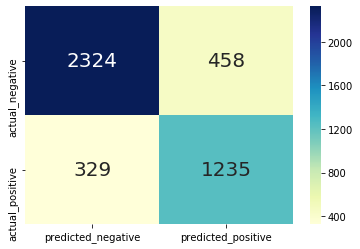

In [77]:
y_pred= logreg.predict(X_test_tfidf)
conf_matrix(y_test,y_pred)

#### Pickle Logistic Regression

In [78]:
logreg = Model[1] # NEED THIS FOR FLASK 

joblib.dump(logreg, './LogReg_model.pkl')


['./LogReg_model.pkl']